In [39]:
pip install pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [41]:
import pandas as pd

# Fear Greed Index
fear_df = pd.read_csv('fear_greed_index.csv')
fear_df['date'] = pd.to_datetime(fear_df['date'])  # Convert date to proper format

# Historical Data
hist_df = pd.read_csv('historical_data.csv')
hist_df['Timestamp IST'] = hist_df['Timestamp IST'].astype(str)  # Ensure it's string
hist_df['date'] = pd.to_datetime(hist_df['Timestamp IST'].str[:10], format='%d-%m-%Y')  # Extract date

# Check data
print(fear_df.head())  # First 5 rows of sentiment data
print(hist_df.head())  # First 5 rows of trade data

    timestamp  value classification       date
0  1517463000     30           Fear 2018-02-01
1  1517549400     15   Extreme Fear 2018-02-02
2  1517635800     40           Fear 2018-02-03
3  1517722200     24   Extreme Fear 2018-02-04
4  1517808600     11   Extreme Fear 2018-02-05
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     10

In [43]:
close_df = hist_df[hist_df['Closed PnL'] != 0]  

In [45]:
daily_trades = close_df.groupby('date').agg({
    'Closed PnL': 'sum',  # Total daily profit/loss
    'Size USD': 'sum'     # Total trade volume
}).reset_index()

In [47]:
merged_df = pd.merge(daily_trades, fear_df[['date', 'value', 'classification']], on='date', how='inner')
print(merged_df.head())  

        date   Closed PnL  Size USD  value classification
0 2023-12-14  -205.434737  76736.39     72          Greed
1 2023-12-15   -24.632034  10609.95     70          Greed
2 2023-12-17   304.982785  65965.81     73          Greed
3 2023-12-19  1000.538612  61883.49     73          Greed
4 2023-12-20   162.732282  70899.75     74          Greed


In [49]:
# Correlation between sentiment value and PnL
print(merged_df.corr(numeric_only=True))

# Average PnL by sentiment class
print(merged_df.groupby('classification')['Closed PnL'].mean())

            Closed PnL  Size USD     value
Closed PnL    1.000000  0.309377 -0.098367
Size USD      0.309377  1.000000 -0.286776
value        -0.098367 -0.286776  1.000000
classification
Extreme Fear     52793.589178
Extreme Greed    25140.475099
Fear             44762.072555
Greed            12875.025587
Neutral          23507.648646
Name: Closed PnL, dtype: float64


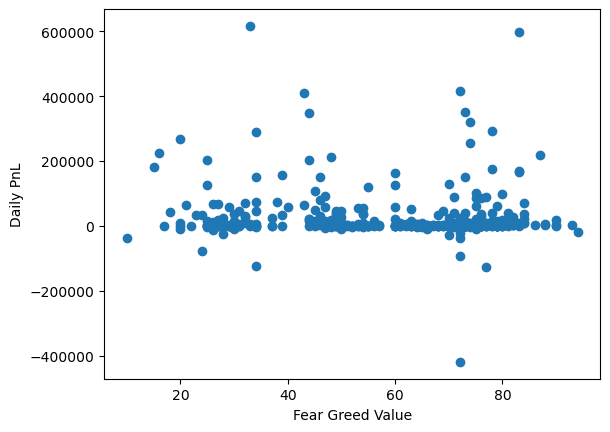

In [51]:
import matplotlib.pyplot as plt
plt.scatter(merged_df['value'], merged_df['Closed PnL'])
plt.xlabel('Fear Greed Value')
plt.ylabel('Daily PnL')
plt.show()

In [53]:
print("Average PnL by Sentiment Classification:")
print(merged_df.groupby('classification')['Closed PnL'].mean())

print("\nTotal PnL and Volume by Classification:")
print(merged_df.groupby('classification').agg({
    'Closed PnL': ['sum', 'count'],  
    'Size USD': 'sum' 
}))

print("\nCorrelation Matrix:")
print(merged_df[['value', 'Closed PnL', 'Size USD']].corr())

Average PnL by Sentiment Classification:
classification
Extreme Fear     52793.589178
Extreme Greed    25140.475099
Fear             44762.072555
Greed            12875.025587
Neutral          23507.648646
Name: Closed PnL, dtype: float64

Total PnL and Volume by Classification:
                  Closed PnL            Size USD
                         sum count           sum
classification                                  
Extreme Fear    7.391102e+05    14  5.689554e+07
Extreme Greed   2.715171e+06   108  5.796224e+07
Fear            3.357155e+06    75  2.396903e+08
Greed           2.150129e+06   167  1.369240e+08
Neutral         1.292921e+06    55  1.008995e+08

Correlation Matrix:
               value  Closed PnL  Size USD
value       1.000000   -0.098367 -0.286776
Closed PnL -0.098367    1.000000  0.309377
Size USD   -0.286776    0.309377  1.000000


In [55]:
# Filter original hist_df for closing trades and group by account/coin
close_df = hist_df[hist_df['Closed PnL'] != 0]
close_df = pd.merge(close_df, fear_df[['date', 'value', 'classification']], on='date', how='inner')

# PnL by account
print("\nPnL by Account:")
print(close_df.groupby(['Account', 'classification'])['Closed PnL'].mean())

# PnL by coin
print("\nPnL by Coin:")
print(close_df.groupby(['Coin', 'classification'])['Closed PnL'].mean())


PnL by Account:
Account                                     classification
0x083384f897ee0f19899168e3b1bec365f52a9012  Extreme Fear      3372.141120
                                            Extreme Greed     -163.749333
                                            Fear              1059.346858
                                            Greed             1808.622681
                                            Neutral            512.857619
                                                                 ...     
0xbee1707d6b44d4d52bfe19e41f8a828645437aab  Extreme Fear        10.692874
                                            Extreme Greed      105.931741
                                            Fear                 8.696411
                                            Greed               55.017973
                                            Neutral              6.317960
Name: Closed PnL, Length: 150, dtype: float64

PnL by Coin:
Coin   classification
@1     Extreme Greed     33.

In [57]:
# BUY/SELL and sentiment
print("\nTrade Count by Side and Classification:")
print(hist_df.merge(fear_df[['date', 'classification']], on='date', how='inner')
      .groupby(['Side', 'classification'])['Account'].count())


Trade Count by Side and Classification:
Side  classification
BUY   Extreme Fear      10935
      Extreme Greed     17940
      Fear              30270
      Greed             24576
      Neutral           18969
SELL  Extreme Fear      10465
      Extreme Greed     22052
      Fear              31567
      Greed             25727
      Neutral           18717
Name: Account, dtype: int64


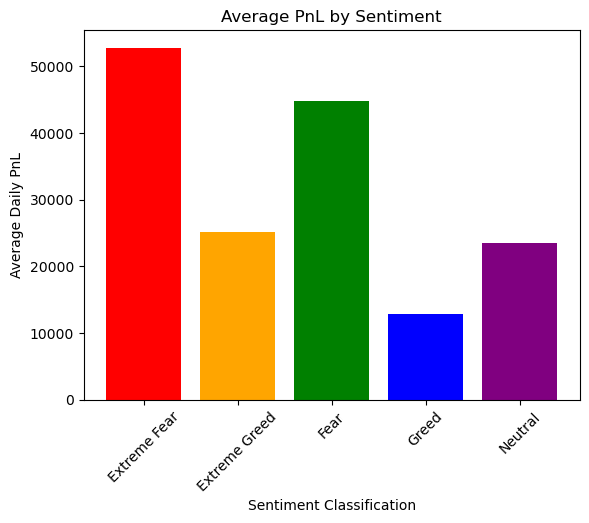

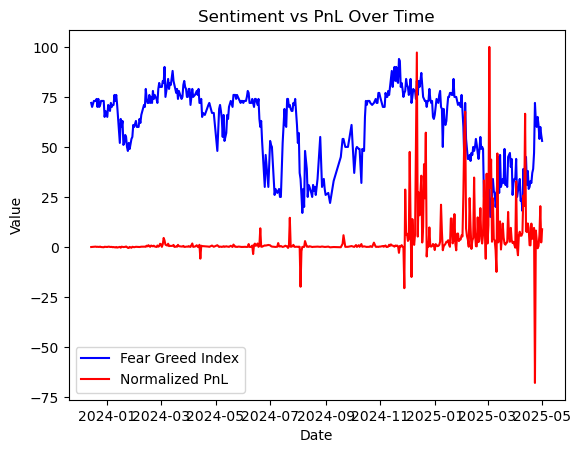

In [59]:
# Bar plot of average PnL by classification
import matplotlib.pyplot as plt
avg_pnl = merged_df.groupby('classification')['Closed PnL'].mean()
plt.bar(avg_pnl.index, avg_pnl.values, color=['red', 'orange', 'green', 'blue', 'purple'])
plt.xlabel('Sentiment Classification')
plt.ylabel('Average Daily PnL')
plt.title('Average PnL by Sentiment')
plt.xticks(rotation=45)
plt.show()

# Line plot of sentiment and PnL over time
plt.plot(merged_df['date'], merged_df['value'], label='Fear Greed Index', color='blue')
plt.plot(merged_df['date'], merged_df['Closed PnL'] / merged_df['Closed PnL'].max() * 100, label='Normalized PnL', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Sentiment vs PnL Over Time')
plt.legend()
plt.show()

In [61]:
# Statistical test (Greed vs Extreme)
greed_pnl = merged_df[merged_df['classification'] == 'Greed']['Closed PnL']
extreme_greed_pnl = merged_df[merged_df['classification'] == 'Extreme Greed']['Closed PnL']
if len(greed_pnl) > 0 and len(extreme_greed_pnl) > 0:
    print("\nT-test (Greed vs Extreme Greed PnL):")
    print(ttest_ind(greed_pnl, extreme_greed_pnl, equal_var=False))
else:
    print("\nNot enough data for T-test in Greed or Extreme Greed.")


T-test (Greed vs Extreme Greed PnL):
TtestResult(statistic=-1.3851549402622256, pvalue=0.16747001889259053, df=210.67316152432545)
